<a href="https://colab.research.google.com/github/Ajaybezawada/Movie_Recommendation_system-/blob/main/Movie_Recommendation_system_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import re
import os
import warnings
warnings.filterwarnings('ignore')
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
rating_df = pd.read_csv('https://raw.githubusercontent.com/maheshv18/ContentBasedMovieRecommender/main/rating.csv', parse_dates=['timestamp'], dtype={'userId': 'uint32', 'movieId': 'uint32', 'rating': 'float32'})
movie_df = pd.read_csv('https://raw.githubusercontent.com/maheshv18/ContentBasedMovieRecommender/c56576d7ed0ac41503db06287d32f32bff4f7547/movie.csv', dtype={'movieId': 'uint32'})
df_gscores=pd.read_csv('https://raw.githubusercontent.com/maheshv18/ContentBasedMovieRecommender/main/genome_scores.csv')
df_gtag=pd.read_csv('https://raw.githubusercontent.com/maheshv18/ContentBasedMovieRecommender/main/genome_tags.csv')
rating_df.shape, movie_df.shape,df_gscores.shape

((231146, 4), (27278, 3), (165781, 3))

# PreProcessing and Cleaning

In [3]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-02-04 23:53:00
1,1,29,3.5,2005-02-04 23:31:00
2,1,32,3.5,2005-02-04 23:33:00
3,1,47,3.5,2005-02-04 23:32:00
4,1,50,3.5,2005-02-04 23:29:00


In [5]:
movie_df.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

In [6]:
print('The total number of movies in the dataset : {}'.format(len(movie_df['movieId'].unique())))

The total number of movies in the dataset : 27278


In [7]:
df_tmp=movie_df[movie_df.duplicated(subset = 'title', keep = False)]
list1=[]
list2=[]
for j in range(32):
    x=0
    for i in range(31):
        if df_tmp.iloc[j,1]== df_tmp.iloc[i+1,1]:
            if df_tmp.iloc[j,2]== df_tmp.iloc[i+1,2]:
                x+=1
                if x>1:
                    list1.append(df_tmp.iloc[j,1])
                else:
                    list2.append(df_tmp.iloc[j,1])
                    
print('List of duplicate movies with same genres {}'.format(list(set(list1))))
print('')
print('List of dullicate movies with different genres {}'.format(list(set(list2)-set(list1))))

List of duplicate movies with same genres ['Beneath (2013)', 'Johnny Express (2014)', 'Clear History (2013)', 'Offside (2006)', 'Girl, The (2012)', 'Darling (2007)']

List of dullicate movies with different genres ['Emma (1996)', '20,000 Leagues Under the Sea (1997)', 'Chaos (2005)', 'Hamlet (2000)', 'Paradise (2013)', 'Men with Guns (1997)', 'War of the Worlds (2005)', 'Casanova (2005)', 'Aladdin (1992)', 'Blackout (2007)']


In [8]:
movie_df.drop_duplicates(subset='title', inplace = True, keep= 'first')
movie_df[movie_df.duplicated(subset = 'title', keep = False)]

,movieId,title,genres


In [9]:
print('The number of movies which are rated by users : {}'.format(len(rating_df['movieId'].unique())))

The number of movies which are rated by users : 10372


In [10]:
count_ratings = pd.DataFrame(rating_df.groupby('rating').count())
count_ratings['perc_total']=round(count_ratings['userId']*100/count_ratings['userId'].sum(),1)
count_ratings['perc_total']

rating
0.5     1.5
1.0     3.7
1.5     1.4
2.0     7.3
2.5     4.3
3.0    21.8
3.5    10.7
4.0    27.5
4.5     7.5
5.0    14.2
Name: perc_total, dtype: float64

In [11]:
gc = pd.DataFrame(movie_df.groupby('genres')['genres'].count())
gc.rename(columns = {'genres':'Count'}, inplace = True)
gc

,Count
genres,
(no genres listed),246
Action,178
Action|Adventure,86
Action|Adventure|Animation,18
Action|Adventure|Animation|Children,8
...,...
Thriller|War,9
Thriller|Western,2
War,32


In [12]:
len(rating_df['userId'].unique())

1596

In [13]:
rating_df['gave_rating_year'] = rating_df['timestamp'].dt.year
rating_df['gave_rating_month'] = rating_df['timestamp'].dt.month_name().str[:3]

rating_df.drop('timestamp', axis=1, inplace=False)

,userId,movieId,rating,gave_rating_year,gave_rating_month
0,1,2,3.5,2005,Feb
1,1,29,3.5,2005,Feb
2,1,32,3.5,2005,Feb
3,1,47,3.5,2005,Feb
4,1,50,3.5,2005,Feb
...,...,...,...,...,...
231141,1596,552,2.0,2005,Apr
231142,1596,593,4.5,2005,Apr
231143,1596,653,3.0,2005,Apr
231144,1596,784,2.0,2005,Apr


In [14]:
rating_df['sentiment_analysis'] = rating_df['rating'].map({
    0.5: 'Negative', 1.0: 'Negative', 1.5: 'Negative', 2.0: 'Negative', 2.5: 'Negative',
    3.0: 'Neutral', 3.5: 'Neutral',
    4.0: 'Positive', 4.5: 'Positive', 5.0: 'Positive'
})

In [15]:
rating_df.head(3)

,userId,movieId,rating,timestamp,gave_rating_year,gave_rating_month,sentiment_analysis
0,1,2,3.5,2005-02-04 23:53:00,2005,Feb,Neutral
1,1,29,3.5,2005-02-04 23:31:00,2005,Feb,Neutral
2,1,32,3.5,2005-02-04 23:33:00,2005,Feb,Neutral


In [16]:
movie_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [17]:
final_df = pd.merge(rating_df, movie_df, on='movieId', how='inner')  # by default ‘inner’
final_df.shape

(231141, 9)

In [18]:
final_df.head()

,userId,movieId,rating,timestamp,gave_rating_year,gave_rating_month,sentiment_analysis,title,genres
0,1,2,3.5,2005-02-04 23:53:00,2005,Feb,Neutral,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,1996-12-25 15:26:00,1996,Dec,Neutral,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,1996-11-27 08:19:00,1996,Nov,Neutral,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,1996-06-23 20:36:00,1996,Jun,Neutral,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,1996-10-28 13:29:00,1996,Oct,Neutral,Jumanji (1995),Adventure|Children|Fantasy


In [19]:
d=rating_df.groupby('movieId').mean()['rating']
df=pd.DataFrame(d, columns=['rating']).reset_index()
df.head()

,movieId,rating
0,1,4.000000
1,2,3.284000
2,3,3.193104
3,4,3.038461
4,5,3.144295


In [20]:
df2=pd.merge(movie_df, df, on='movieId', how='left' )
df2['Year']=df2['title'].str.extract('.*\((.*)\).*')
df2.head()

,movieId,title,genres,rating,Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.000000,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.284000,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,3.193104,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3.038461,1995
4,5,Father of the Bride Part II (1995),Comedy,3.144295,1995


In [21]:
df2['Year'].replace(['Das Millionenspiel','Bicicleta, cullera, poma','2007-','2009– ', '1975-1979', '1983)'], value=[np.nan, np.nan, '2007', '2009', '1975', '1983' ], inplace=True)

In [22]:
genres_lis=['Romance', 'Fantasy', 'Animation', 'Action', 'Film-Noir', 'Adventure', 'Horror', 'IMAX', 'Musical', 'War', 'Drama', 'Comedy', 'Crime', 'Mystery', '(no genres listed)', 'Documentary', 'Western', 'Thriller', 'Children', 'Sci-Fi']
df3=df_gscores[df_gscores.groupby('movieId')['relevance'].transform(max)==df_gscores['relevance']]
df3=df3.drop_duplicates(subset='movieId')
df4=pd.merge(df3, df_gtag, how='left', on='tagId')
df5=pd.merge(df2, df4, how='left', on='movieId')
df5.rename(mapper={'tag':'High_relevance_tag', 'tagId':'High_relevance_tagId'}, axis=1, inplace=True)
for i in range(len(genres_lis)):
    df5[genres_lis[i]]=df5['genres'].str.contains(genres_lis[i])

Both datasets don't have missing or duplicated values

Add new features using datetime for analysist & EDA

# Visualization

(array([ 3530.,  8556.,  3254., 16930., 10049., 50408., 24754., 63493.,
        17337., 32835.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ],
       dtype=float32),
 <a list of 10 Patch objects>)

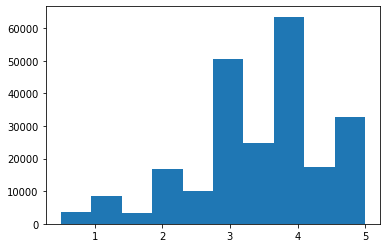

In [23]:
plt.hist(rating_df['rating'])

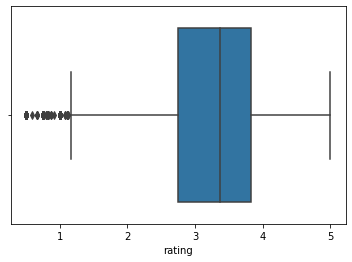

In [24]:
sns.boxplot(df['rating'], orient='v')

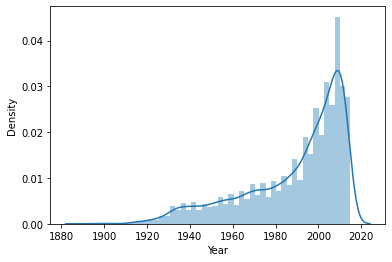

In [25]:
sns.distplot(df2['Year'].dropna().astype('int64'))

In [26]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
el = rating_df["rating"].value_counts().reset_index()
el.columns = ["rating", "percent"]
el["percent"] /= rating_df.shape[0]

fig = px.pie(el,
            names="rating",
            values="percent",
            title = "Rating Percent",
            width = 600,
            height=400
            )
fig.show()

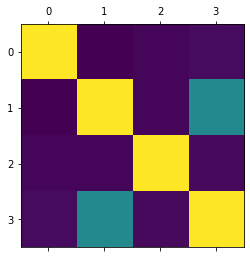

In [27]:
import matplotlib.pyplot as plt
plt.matshow(rating_df.corr())
plt.show()

In [28]:
genres_lis=['Romance', 'Fantasy', 'Animation', 'Action', 'Film-Noir', 'Adventure', 'Horror', 'IMAX', 'Musical', 'War', 'Drama', 'Comedy', 'Crime', 'Mystery', '(no genres listed)', 'Documentary', 'Western', 'Thriller', 'Children', 'Sci-Fi']

Text(0.5, 1.0, 'Avg. Rating W.R.T Genres')

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

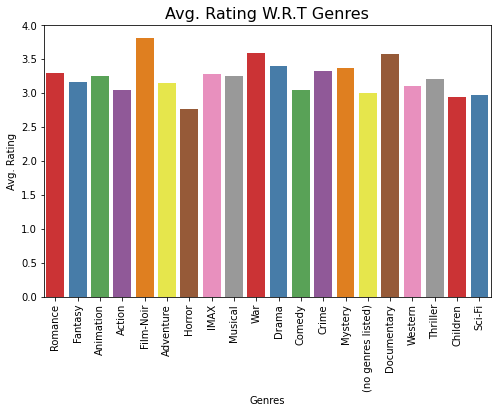

In [29]:
avg_rating=[]
for genre in genres_lis:
    avg_rating.append(df2[df2['genres'].str.contains(genre)]['rating'].mean())
    plt.figure(figsize=(8,5))
sns.barplot(genres_lis, avg_rating,palette='Set1')
plt.xticks(rotation='vertical')
plt.ylabel('Avg. Rating')
plt.xlabel('Genres')
plt.title('Avg. Rating W.R.T Genres', fontsize=16)

In [30]:
movie_genres = []

for genre in movie_df['genres']:
    for movie in genre.split('|'):
        movie_genres.append(movie)

In [31]:
genre_counts = pd.Series(movie_genres).value_counts()[:18]

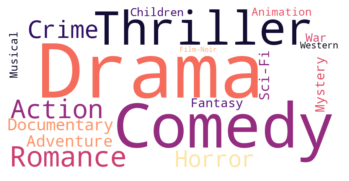

In [32]:
from wordcloud import WordCloud

genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='magma')
genres_cloud.generate_from_frequencies(genre_counts)

plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

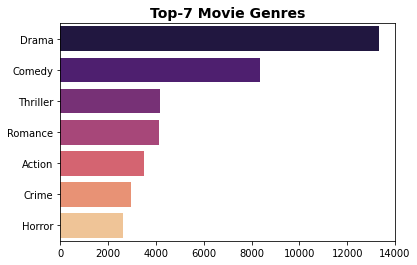

In [33]:
top_7_genres = pd.Series(movie_genres).value_counts()[:7]

sns.barplot(y=top_7_genres.index, x=top_7_genres.values, palette='magma').set_title(
        'Top-7 Movie Genres', fontsize=14, weight='bold')

plt.show()

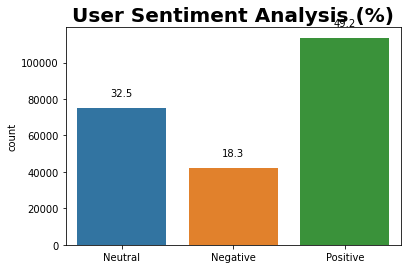

In [34]:
splot1 = sns.countplot(final_df['sentiment_analysis'])

for p in splot1.patches:
                splot1.annotate(format(p.get_height() / final_df['rating'].shape[0] * 100, '.1f'),
                                (p.get_x() + p.get_width() / 2., p.get_height()),
                               rotation=0, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')
        
plt.xlabel(None)
plt.title('User Sentiment Analysis (%)', fontsize=20, weight='bold')
plt.show()

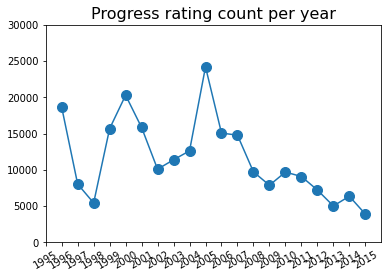

In [35]:
def plot_progress_year(feature, title):
    rating_progress = final_df.groupby(feature)['userId'].count()
    
    plt.plot(rating_progress, linestyle='-', marker='o', markersize=10)
    plt.title(title, fontsize=16)
    plt.xticks([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], rotation=30)
    plt.ylim([0, 30000])
    plt.show()

plot_progress_year('gave_rating_year', 'Progress rating count per year')

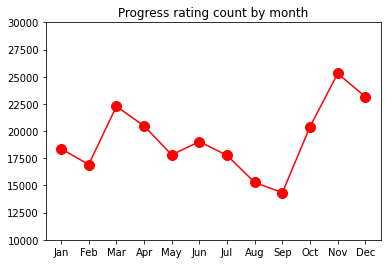

In [36]:
df_index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_progress = final_df.groupby('gave_rating_month').userId.count().reindex(df_index)

plt.plot(month_progress, linestyle='-', color='red', marker='o', markersize=10)
plt.title('Progress rating count by month')
plt.ylim([10000, 30000])
plt.show()

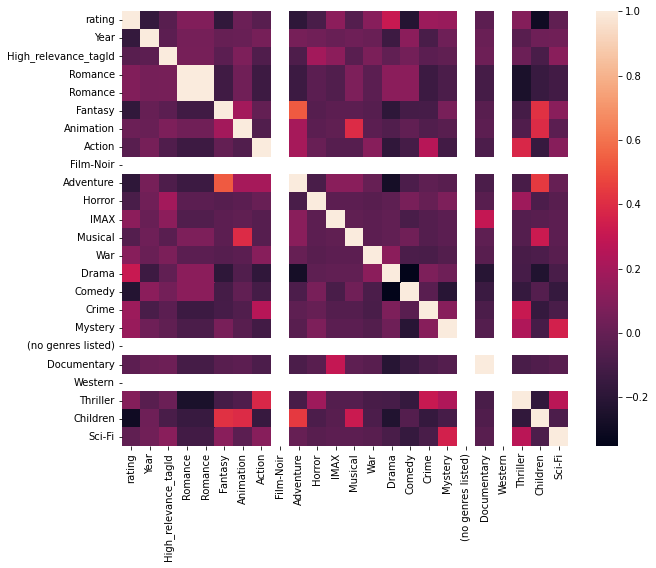

In [37]:
df5=df5.dropna()
df5['Year']=df5['Year'].astype('int64')
plt.figure(figsize = (10,8))
sns.heatmap(df5[['rating', 'Year', 'High_relevance_tagId','Romance', 'Romance', 'Fantasy', 'Animation',
       'Action', 'Film-Noir', 'Adventure', 'Horror', 'IMAX', 'Musical', 'War',
       'Drama', 'Comedy', 'Crime', 'Mystery', '(no genres listed)',
       'Documentary', 'Western', 'Thriller', 'Children', 'Sci-Fi']].corr(), annot=False)

# Data Cleaning

Both datasets don't have missing or duplicated values

Add new features using datetime for analysist & EDA

In [38]:
rating_df['gave_rating_year'] = rating_df['timestamp'].dt.year
rating_df['gave_rating_month'] = rating_df['timestamp'].dt.month_name().str[:3]
rating_df.drop('timestamp', axis=1, inplace=False)

,userId,movieId,rating,gave_rating_year,gave_rating_month,sentiment_analysis
0,1,2,3.5,2005,Feb,Neutral
1,1,29,3.5,2005,Feb,Neutral
2,1,32,3.5,2005,Feb,Neutral
3,1,47,3.5,2005,Feb,Neutral
4,1,50,3.5,2005,Feb,Neutral
...,...,...,...,...,...,...
231141,1596,552,2.0,2005,Apr,Negative
231142,1596,593,4.5,2005,Apr,Positive
231143,1596,653,3.0,2005,Apr,Neutral
231144,1596,784,2.0,2005,Apr,Negative


In [39]:
rating_df['sentiment_analysis'] = rating_df['rating'].map({
    0.5: 'Negative', 1.0: 'Negative', 1.5: 'Negative', 2.0: 'Negative', 2.5: 'Negative',
    3.0: 'Neutral', 3.5: 'Neutral',
    4.0: 'Positive', 4.5: 'Positive', 5.0: 'Positive'
})

In [40]:
rating_df.head(3)

,userId,movieId,rating,timestamp,gave_rating_year,gave_rating_month,sentiment_analysis
0,1,2,3.5,2005-02-04 23:53:00,2005,Feb,Neutral
1,1,29,3.5,2005-02-04 23:31:00,2005,Feb,Neutral
2,1,32,3.5,2005-02-04 23:33:00,2005,Feb,Neutral


In [41]:
movie_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [42]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
rating_df['sentiment_analysis']= label_encoder.fit_transform(rating_df['sentiment_analysis'])

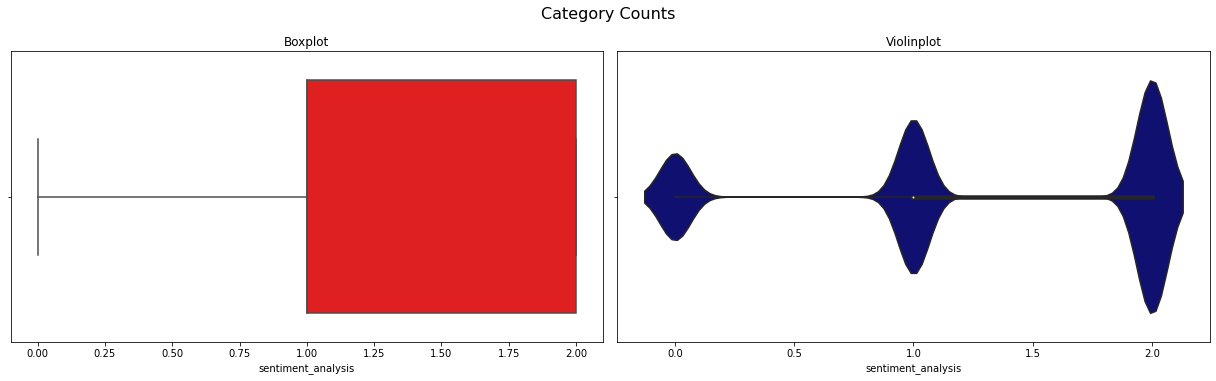

In [43]:
plt.rcParams["figure.figsize"] = [17, 5]
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(1, 2)
fig.suptitle("Category Counts", fontsize=16,y=1.05)

axes[0].set_title("Boxplot")
axes[1].set_title("Violinplot")


sns.boxplot(x=rating_df['sentiment_analysis'],ax=axes[0],color='red')
sns.violinplot(x=rating_df['sentiment_analysis'],ax=axes[1],color='navy')

In [44]:
rating_df = rating_df[rating_df['rating'] > 0 ]

In [45]:
rating_df = rating_df[rating_df['sentiment_analysis'] > 0]

In [46]:
rating_df[rating_df['rating']  < 1 ]

,userId,movieId,rating,timestamp,gave_rating_year,gave_rating_month,sentiment_analysis


# TF-IDF vectorizer using Cosine Similarity

In [47]:
genres_str = movie_df['genres'].str.split('|').astype(str)

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0)
tfidf_matrix = tfidf.fit_transform(genres_str)
tfidf_matrix.shape

(27262, 191)

In [49]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.31699788, 0.06280943, 0.05664235],
       [0.31699788, 1.        , 0.        , 0.        ],
       [0.06280943, 0.        , 1.        , 0.36002001],
       [0.05664235, 0.        , 0.36002001, 1.        ]])

In [50]:
indices = pd.Series(movie_df.index, index=movie_df['title'])

# Recommender based on cosine similarity score of movie genres
def genre_recommendations(title, similarity=False):
    
    if similarity == False:   
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:10] 
    
        movie_indices = [i[0] for i in sim_scores]
    
        return pd.DataFrame({'Movie': movie_df['title'].iloc[movie_indices].values})
    
    
    elif similarity == True:
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:10]
        
        movie_indices = [i[0] for i in sim_scores]
        similarity_ = [i[1] for i in sim_scores]
        
        return pd.DataFrame({'Movie': movie_df['title'].iloc[movie_indices].values,
                             'Similarity': similarity_})

In [51]:
print(indices)

title
Toy Story (1995)                          0
Jumanji (1995)                            1
Grumpier Old Men (1995)                   2
Waiting to Exhale (1995)                  3
Father of the Bride Part II (1995)        4
                                      ...  
Kein Bund für's Leben (2007)          27273
Feuer, Eis & Dosenbier (2002)         27274
The Pirates (2014)                    27275
Rentun Ruusu (2001)                   27276
Innocence (2014)                      27277
Length: 27262, dtype: int64


In [52]:
genre_recommendations('Kung Fu Panda (2008)', similarity=True)

,Movie,Similarity
0,Heidi Fleiss: Hollywood Madam (1995),1.0
1,Catwalk (1996),1.0
2,Anne Frank Remembered (1995),1.0
3,Jupiter's Wife (1994),1.0
4,Sonic Outlaws (1995),1.0
5,From the Journals of Jean Seberg (1995),1.0
6,Man of the Year (1995),1.0
7,Crumb (1994),1.0
8,"Show, The (1995)",1.0


In [53]:
genre_recommendations("Indiana Jones and the Temple of Doom (1984)", similarity=True)

,Movie,Similarity
0,Street Fighter (1994),1.0
1,Dragonheart (1996),1.0
2,Highlander (1986),1.0
3,Conan the Barbarian (1982),1.0
4,Mortal Kombat: Annihilation (1997),1.0
5,Indiana Jones and the Temple of Doom (1984),1.0
6,Willow (1988),1.0
7,Red Sonja (1985),1.0
8,"13th Warrior, The (1999)",1.0


In [54]:
movie_df['movie_release_year'] = movie_df['title'].str.extract(r'(?:\((\d{4})\))?\s*$', expand=False)

In [55]:
def genre_recommendations_2(title, most_recent=False):
    
    if most_recent == False:
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:10] 
    
        movie_indices = [i[0] for i in sim_scores]
    
        return pd.DataFrame({'Movie': movie_df['title'].iloc[movie_indices].values})
    
    
    elif most_recent == True:
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:14]
        
        movie_indices = [i[0] for i in sim_scores]
        similarity_ = [i[1] for i in sim_scores]
        most_recent_movie = pd.DataFrame({'Movie': movie_df['title'].iloc[movie_indices].values,
                                          'release_year': movie_df['movie_release_year'].iloc[movie_indices].values,
                                          'Similarity': similarity_})
        
        return most_recent_movie.sort_values('release_year', ascending=False).head(10)

In [56]:
genre_recommendations_2('Green Hornet, The (2011)', most_recent=True)

,Movie,release_year,Similarity
10,The White Haired Witch of Lunar Kingdom (2014),2014,0.636952
11,Jack the Giant Killer (2013),2013,0.636952
0,BloodRayne: Deliverance (BloodRayne II: Delive...,2007,1.000000
5,BloodRayne (2005),2005,0.636952
9,Ashura (2005),2005,0.636952
2,Purgatory (1999),1999,0.823659
8,Rebirth of Mothra II (1997),1997,0.636952
12,Tall Tale (1995),1995,0.615392
3,Highlander III: The Sorcerer (a.k.a. Highlande...,1994,0.636952
7,"Evil Cult, The (Lord of the Wu Tang) (Yi tian ...",1993,0.636952


In [57]:
rating_mean = final_df.groupby('title')['rating'].mean().reset_index()
total_rating = final_df.groupby('title')['rating'].count().reset_index()

total_rating_mean = pd.merge(rating_mean, total_rating, on='title', how='inner')
total_rating_mean.rename(columns={'rating_x': 'rating_mean',
                                  'rating_y': 'total_rating'},
                                  inplace=True)

final_df2 = movie_df.merge(total_rating_mean, on='title', how='left').dropna()

In [58]:
def genre_recommendations_3(title, best_rating=False):
    
    if best_rating == False:  # recommendation based on total rating
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:14]
    
        movie_indices = [i[0] for i in sim_scores]
        
        most_rating_movie = pd.DataFrame({'Movie': final_df2['title'].iloc[movie_indices].values,
                                          'total_rating': final_df2['total_rating'].iloc[movie_indices].values})
    
        return most_rating_movie.sort_values('total_rating', ascending=False).head(10)
    
    
    elif best_rating == True:  # sort by best rating
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:14]
        
        movie_indices = [i[0] for i in sim_scores]
        
        most_recent_movie = pd.DataFrame({'Movie': final_df2['title'].iloc[movie_indices].values,
                                          'rating_mean': final_df2['rating_mean'].iloc[movie_indices].values})
        
        return most_recent_movie.sort_values('rating_mean', ascending=False).head(10)

In [59]:
genre_recommendations_3('Taken (2008)', best_rating=True)

,Movie,rating_mean
2,Richard III (1995),3.720339
0,Othello (1995),3.693548
7,Friday (1995),3.424528
1,Dangerous Minds (1995),3.345000
4,Home for the Holidays (1995),3.250000
5,"Confessional, The (Confessionnal, Le) (1995)",3.000000
11,Frankie Starlight (1995),3.000000
12,Down Periscope (1996),2.913793
6,Two if by Sea (1996),2.850000
3,Mortal Kombat (1995),2.626050


#Corr Matrix Based Recommender

In [60]:
df=movie_df.merge(rating_df,"left",on="movieId")
rating_count=pd.DataFrame(df["title"].value_counts())
exc_movies=rating_count[rating_count["title"]<=8000].index
common_movies=df[df["title"].isin(exc_movies)]
user_movie_df=common_movies.pivot_table(index="userId",columns="title",values="rating")

def item_based_recommender(movie_name,user_movie_df):
    movie_name_df=user_movie_df[movie_name]
    return list(user_movie_df.corrwith(movie_name_df).sort_values(ascending=False).head(6).index)

random_user = 1001

movie_code=rating_df[rating_df["userId"]==random_user].sort_values("timestamp", ascending=False).\
sort_values("rating", ascending=False).iloc[0,1]
print('Movie Code ',movie_code)

movie_name=""
for i in (movie_df[movie_df["movieId"]==movie_code]["title"]):
    movie_name+=i

print('Movie Name ',movie_name)
print('')
item_based_recommender(movie_name,user_movie_df)

Movie Code  1033
Movie Name  Fox and the Hound, The (1981)



['John Q (2002)',
 'Fall, The (2006)',
 'Mermaids (1990)',
 'Marked for Death (1990)',
 'Analyze That (2002)',
 'Man Who Would Be King, The (1975)']

# KNN

In [61]:
movie = movie_df.loc[:,{"movieId","title"}]
rating = rating_df.loc[:,{"userId","movieId","rating"}]

In [62]:
data = pd.merge(movie,rating)
data = data.iloc[:1000000,:]
user_movie_table = data.pivot_table(index = ["title"],columns = ["userId"],values = "rating").fillna(0)
user_movie_table.head(5)

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Neath the Arizona Skies (1934),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
query_index = np.random.choice(user_movie_table.shape[0])
print("Choosen Movie is: ",user_movie_table.index[query_index])

Choosen Movie is:  Defiance (2008)


In [64]:
user_movie_table_matrix = csr_matrix(user_movie_table.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(user_movie_table_matrix)
distances, indices = model_knn.kneighbors(user_movie_table.iloc[query_index,:].values.reshape(1,-1), n_neighbors = 6)

In [65]:
movie = []
distance = []

for i in range(0, len(distances.flatten())):
    if i != 0:
        movie.append(user_movie_table.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])    

m=pd.Series(movie,name='movie')
d=pd.Series(distance,name='distance')
recommend = pd.concat([m,d], axis=1)
recommend = recommend.sort_values('distance',ascending=False)

print('Recommendations for {0}:\n'.format(user_movie_table.index[query_index]))
for i in range(0,recommend.shape[0]):
    print('{0}: {1}, with distance of {2}'.format(i, recommend["movie"].iloc[i], recommend["distance"].iloc[i]))

Recommendations for Defiance (2008):

0: Amateurs, The (Moguls, The) (2005), with distance of 0.3862050771713257
1: All About Steve (2009), with distance of 0.37000060081481934
2: Gangster Squad (2013), with distance of 0.3333219289779663
3: This Is 40 (2012), with distance of 0.2766357660293579
4: Haywire (2011), with distance of 0.2232869267463684


# Linear Regression

In [66]:
final_df2.head()

,movieId,title,genres,movie_release_year,rating_mean,total_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,4.000000,560.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3.284000,250.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,3.193104,145.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,3.038461,26.0
4,5,Father of the Bride Part II (1995),Comedy,1995,3.144295,149.0


In [67]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
final_df2['genres']=le.fit_transform(final_df2['genres'])
final_df2.head()

,movieId,title,genres,movie_release_year,rating_mean,total_rating
0,1,Toy Story (1995),328,1995,4.000000,560.0
1,2,Jumanji (1995),389,1995,3.284000,250.0
2,3,Grumpier Old Men (1995),705,1995,3.193104,145.0
3,4,Waiting to Exhale (1995),659,1995,3.038461,26.0
4,5,Father of the Bride Part II (1995),605,1995,3.144295,149.0


In [68]:
final_df4 = final_df2.merge(data,on=['movieId','title'], how='left').dropna()

In [69]:
feature_cols =['movieId','genres','movie_release_year','rating','total_rating']

In [70]:
final_df4.sample(3)

,movieId,title,genres,movie_release_year,rating_mean,total_rating,userId,rating
71366,1278,Young Frankenstein (1974),669,1974,3.938202,178.0,1508.0,4.0
155694,6056,Chaos (2001),607,2001,4.000000,2.0,190.0,4.5
60497,1196,Star Wars: Episode V - The Empire Strikes Back...,120,1980,4.104869,534.0,1550.0,4.0


In [71]:
final_df5 = final_df4[final_df4['movie_release_year'] > str(2000) ]

In [72]:
X = final_df5[feature_cols].values # Features
y = final_df5['rating_mean'].values

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [74]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(X,y, test_size = 0.30, random_state = 42)

In [75]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (27721, 5)
Training Labels Shape: (27721,)
Testing Features Shape: (11881, 5)
Testing Labels Shape: (11881,)


In [76]:
lin_reg = LinearRegression()
lin_reg.fit(train_features,train_labels)

LinearRegression()

In [77]:
linear_y_pred=lin_reg.predict(test_features)

In [78]:
errors = abs(linear_y_pred - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.27 degrees.


In [79]:
from sklearn.metrics import mean_squared_error, r2_score
print("Coefficients: \n", lin_reg.coef_)
lrRMSE = mean_squared_error(test_labels,linear_y_pred)
lrR2 = r2_score(test_labels, linear_y_pred)
print("Mean squared error: %.2f" % lrRMSE)
print("Coefficient of determination: %.2f" % lrR2)

Coefficients: 
 [ 4.39793814e-06  2.68794617e-04 -4.89952241e-03  1.95082242e-01
  2.20282400e-03]
Mean squared error: 0.13
Coefficient of determination: 0.32


# Random Forest

In [80]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 42)

In [81]:
final_df2.head()

,movieId,title,genres,movie_release_year,rating_mean,total_rating
0,1,Toy Story (1995),328,1995,4.000000,560.0
1,2,Jumanji (1995),389,1995,3.284000,250.0
2,3,Grumpier Old Men (1995),705,1995,3.193104,145.0
3,4,Waiting to Exhale (1995),659,1995,3.038461,26.0
4,5,Father of the Bride Part II (1995),605,1995,3.144295,149.0


In [82]:
feature_cols =['movieId','genres','movie_release_year','rating','total_rating','userId']
X = final_df4[feature_cols] # Features
y = final_df4['rating_mean']

In [83]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(X,y, test_size = 0.25, random_state = 42)

In [84]:
regressor.fit(train_features,train_labels)

RandomForestRegressor(n_estimators=500, random_state=42)

In [85]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (141609, 6)
Training Labels Shape: (141609,)
Testing Features Shape: (47203, 6)
Testing Labels Shape: (47203,)


In [86]:
predictions = regressor.predict(test_features)
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.03 degrees.


In [87]:
from sklearn.metrics import mean_squared_error, r2_score
rfRMSE = mean_squared_error(test_labels, predictions)
rfR2 = abs(r2_score(predictions,test_labels))
# The mean squared error
print("Mean squared error:", round(rfRMSE, 2))
print("Coefficient of determination", round(rfR2, 2))

Mean squared error: 0.02
Coefficient of determination 0.91


# K-Means Clustering

In [88]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [89]:
kmeanModel = KMeans(n_clusters=20)
kmeanModel.fit(train_features)

KMeans(n_clusters=20)

In [90]:
train_features['Cluster'] = kmeanModel.labels_
train_features['Cluster'].sample(n=10)

143949     6
90577     15
3040      10
66176      1
54868      1
83138      1
168593    18
95895     15
18512     10
45869     10
Name: Cluster, dtype: int32

In [91]:
train_features.rename(columns = {0:'MovieID',1:'Cluster'},inplace=True)
train_features.drop_duplicates(inplace=True)

In [92]:
train_features[['movieId', 'Cluster']]

,movieId,Cluster
109174,2628,15
86703,1769,1
119654,3016,15
89075,1921,15
29581,454,10
...,...,...
120005,3033,15
103772,2396,15
132106,3723,11
147158,4979,6


In [93]:
train_features['Cluster'].value_counts()

10    34653
1     31127
15    25604
11    15580
6      9459
13     6849
18     3099
8      1871
19     1826
3      1470
9      1465
0      1269
14     1255
17     1081
12     1019
2       984
4       921
5       832
16      665
7       580
Name: Cluster, dtype: int64

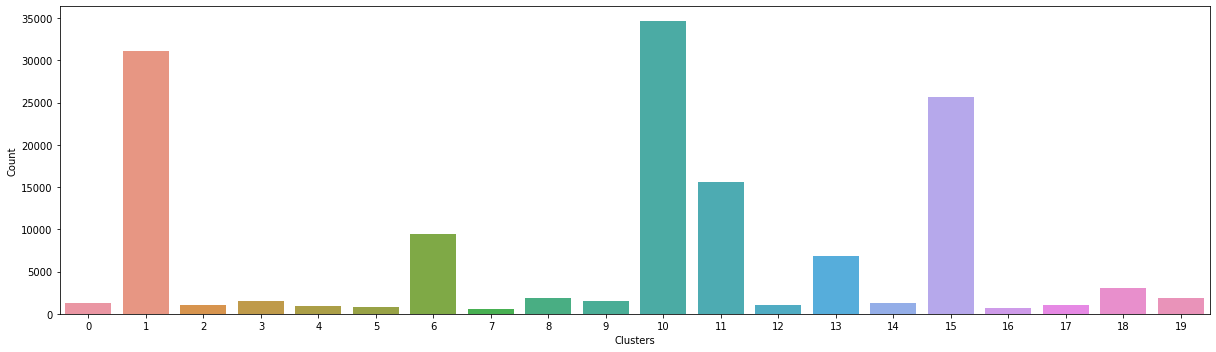

In [94]:
sns.countplot(train_features['Cluster'])
plt.xlabel('Clusters')
plt.ylabel('Count')
plt.show()

In [95]:
kmeanModel.cluster_centers_

array([[4.51449046e+04, 5.39919622e+02, 2.00534752e+03, 3.85736801e+00,
        5.29377463e+01, 7.95969267e+02],
       [1.26928622e+03, 5.65111354e+02, 1.98208984e+03, 3.98980542e+00,
        1.84172971e+02, 8.05255812e+02],
       [8.91854715e+04, 4.38895325e+02, 2.01076016e+03, 3.90853659e+00,
        2.10823171e+01, 7.48648374e+02],
       [6.03962880e+04, 4.38978977e+02, 2.00762649e+03, 3.90469516e+00,
        5.67589348e+01, 7.65979678e+02],
       [2.70956384e+04, 6.23267101e+02, 1.98956026e+03, 3.95331162e+00,
        1.46188925e+01, 7.54116178e+02],
       [7.32142728e+04, 4.81811298e+02, 2.00853125e+03, 3.85096154e+00,
        2.89182692e+01, 7.72597356e+02],
       [5.25263986e+03, 5.73860514e+02, 1.99567975e+03, 3.86903376e+00,
        1.03361308e+02, 7.98733728e+02],
       [1.09483107e+05, 5.23451724e+02, 2.01276207e+03, 3.91206897e+00,
        1.24258621e+01, 7.75110345e+02],
       [3.28361470e+04, 4.71242117e+02, 2.00263442e+03, 3.89230358e+00,
        7.20069482e+01, 

In [96]:
kmeanModel.inertia_

104973422789.24841

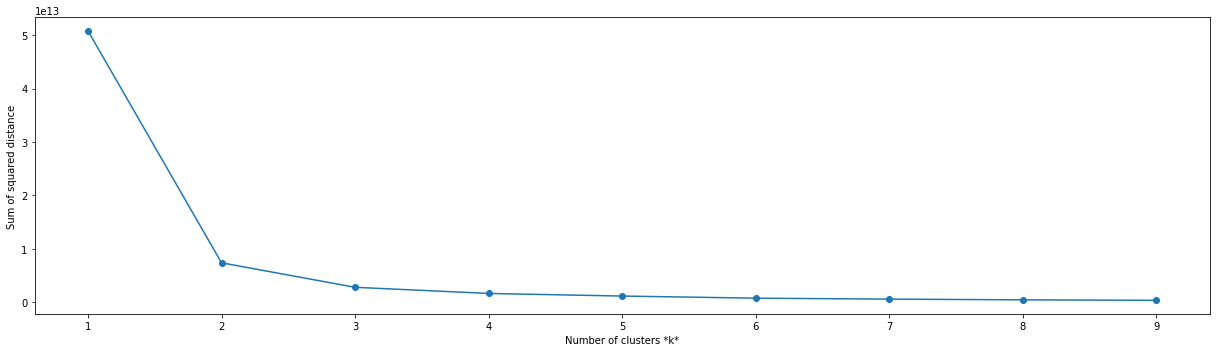

In [97]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(train_features)
    sse.append(km.inertia_)

# Plot sse against k
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

# Comparison

RMSE
0.1287858101570808 (Linear Regression)


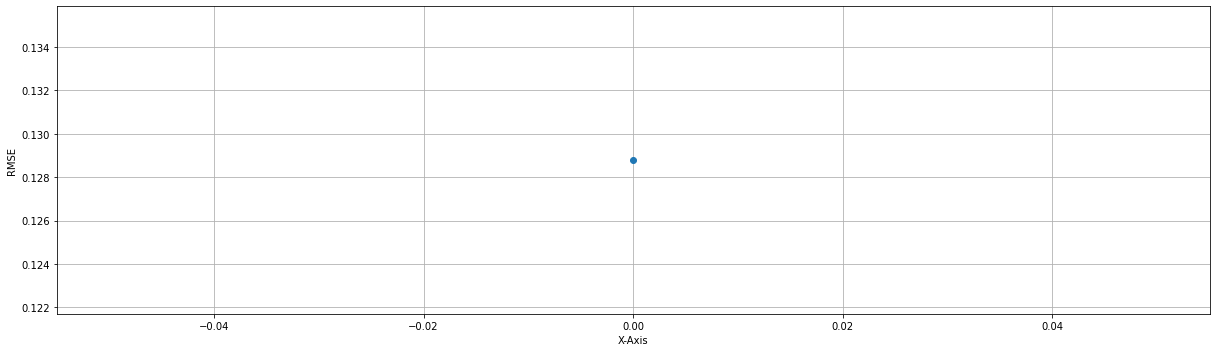

RMSE
0.016305211363057986 (Random Forest)


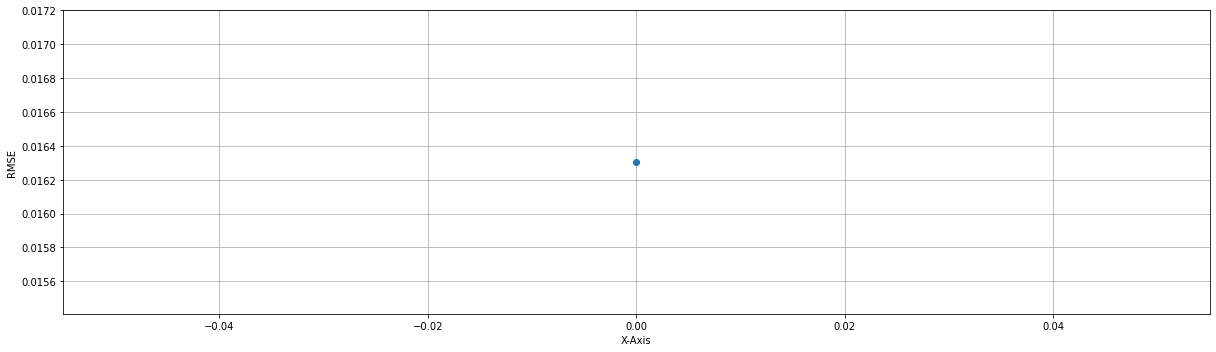

In [98]:
def compRMSE(mse, model):
  print('RMSE\n'+str(mse)+" ("+model+")")
  plt.plot(mse, marker='o')
  plt.ylabel('RMSE')
  plt.xlabel('X-Axis')
  plt.grid()
  plt.show()

compRMSE(lrRMSE, 'Linear Regression')
compRMSE(rfRMSE, 'Random Forest')

R2
0.3201144242230629 (Linear Regression)


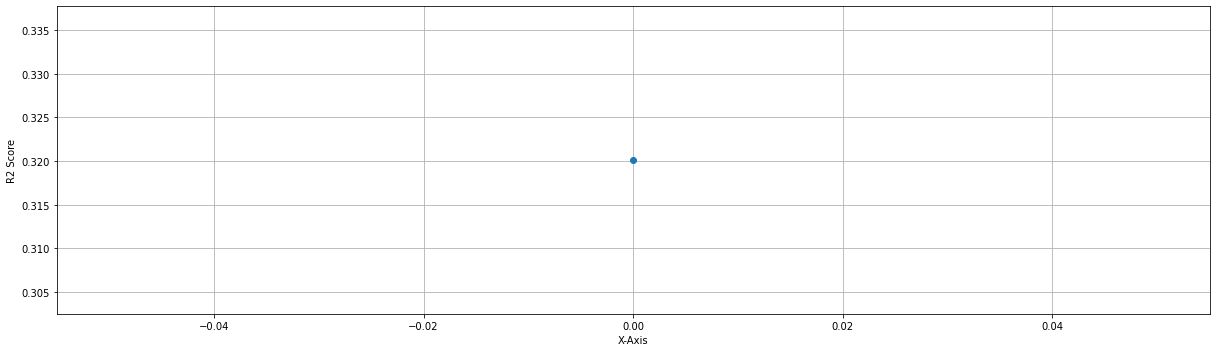

R2
0.908726075686176 (Random Forest)


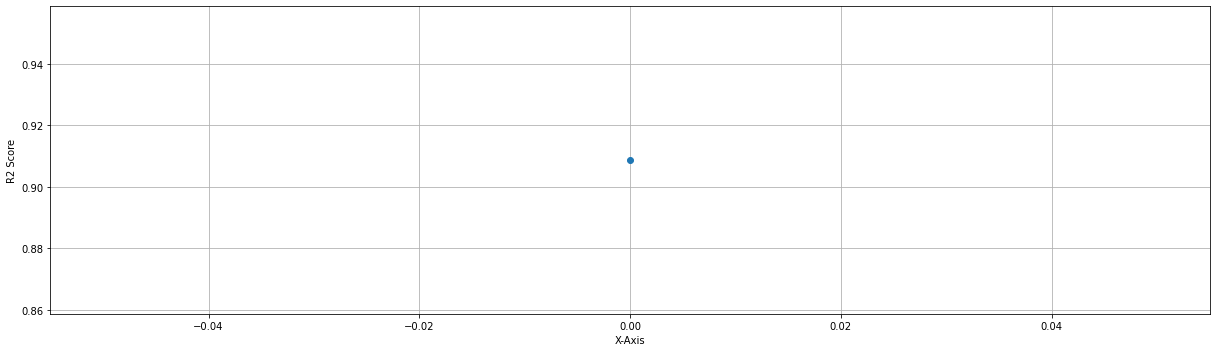

In [99]:
def compR2(r2, model):
  print('R2\n'+str(r2)+" ("+model+")")
  plt.plot(r2, marker='o')
  plt.ylabel('R2 Score')
  plt.xlabel('X-Axis')
  plt.grid()
  plt.show()

compR2(lrR2, 'Linear Regression')
compR2(rfR2, 'Random Forest')